In [2]:
import numpy as np
import torch
from torch import optim
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
from PIL import Image
import torchvision.transforms as transforms
from ccagt_dataset import CCAgT_Dataset
from utils import contours_generate, vs_generate, compress_channel, show_images, plot_training_validation_loss, visualize_metrics, get_all_unique_values
from unet import UNet
from evalaution import pixel_accuracy, class_pixel_accuracy, mean_pixel_accuracy, dice_coefficient, iou, mean_iou, compute_mAP
import random
import torch.optim.lr_scheduler as lr_scheduler
from torchvision.transforms import functional as F

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.is_available())

cuda:0
True


In [4]:
torch.manual_seed(12)
torch.backends.cudnn.deterministic = True

## Create Dataset

In [5]:
img_size = [256, 256]
num_classes = 8
BATCH = 16

In [6]:
class SegmentationTransform:
    def __init__(self, img_size=(256, 256)):
        """
        自定義 transform，實現影像和 mask 的同步幾何變換
        :param img_size: 影像和 mask 調整後的大小
        """
        self.img_size = img_size

    def __call__(self, img, mask):
        # Resize image 和 mask
        img = F.resize(img, self.img_size, interpolation=Image.BILINEAR)
        mask = F.resize(mask, self.img_size, interpolation=Image.NEAREST)

        # 隨機水平翻轉
        if random.random() > 0.5:
            img = F.hflip(img)
            mask = F.hflip(mask)

        # 隨機垂直翻轉
        if random.random() > 0.5:
            img = F.vflip(img)
            mask = F.vflip(mask)

        color_jitter = transforms.ColorJitter(brightness= 0.2, contrast= 0.15, saturation= 0.1, hue= 0.05)
        img = color_jitter(img)

        # 影像增強
        img = F.to_tensor(img)
        img = F.normalize(img, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 標準化到 [-1, 1]

        # Mask 保持為 long 類型
        mask_array = np.array(mask, dtype=np.uint8)
        # 替換 8 和 9 為 0
        mask_array[(mask_array == 8) | (mask_array == 9)] = 0
        mask_tensor = torch.tensor(mask_array, dtype=torch.long)

        return img, mask_tensor
    
class TestSegmentationTransform:
    def __init__(self, img_size=(256, 256)):
        """
        測試階段的 transform
        :param img_size: 影像和 mask 的調整大小
        """
        self.img_size = img_size

    def __call__(self, img, mask):
        # Resize image 和 mask
        img = F.resize(img, self.img_size, interpolation=Image.BILINEAR)
        mask = F.resize(mask, self.img_size, interpolation=Image.NEAREST)

        # 影像處理
        img = F.to_tensor(img)
        img = F.normalize(img, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 標準化到 [-1, 1]

        # Mask 保持為 long 類型
        mask_array = np.array(mask, dtype=np.uint8)
        mask_tensor = torch.tensor(mask_array, dtype=torch.long)

        return img, mask_tensor

In [7]:
img_dir = "size_512\images_crop"
mask_dir = "size_512\masks_crop"

train_val_transform = SegmentationTransform(img_size=img_size)
test_transform = SegmentationTransform(img_size=img_size)

train_dataset = CCAgT_Dataset(img_dir, mask_dir, split='train', transform=train_val_transform)
val_dataset = CCAgT_Dataset(img_dir, mask_dir, split='val', transform=train_val_transform)
test_dataset = CCAgT_Dataset(img_dir, mask_dir, split='test', transform=test_transform)

trainloader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=BATCH, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=BATCH, shuffle=False)

In [8]:
# get_all_unique_values(val_dataset)

{0, 1, 2, 3, 4, 5, 6, 7}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


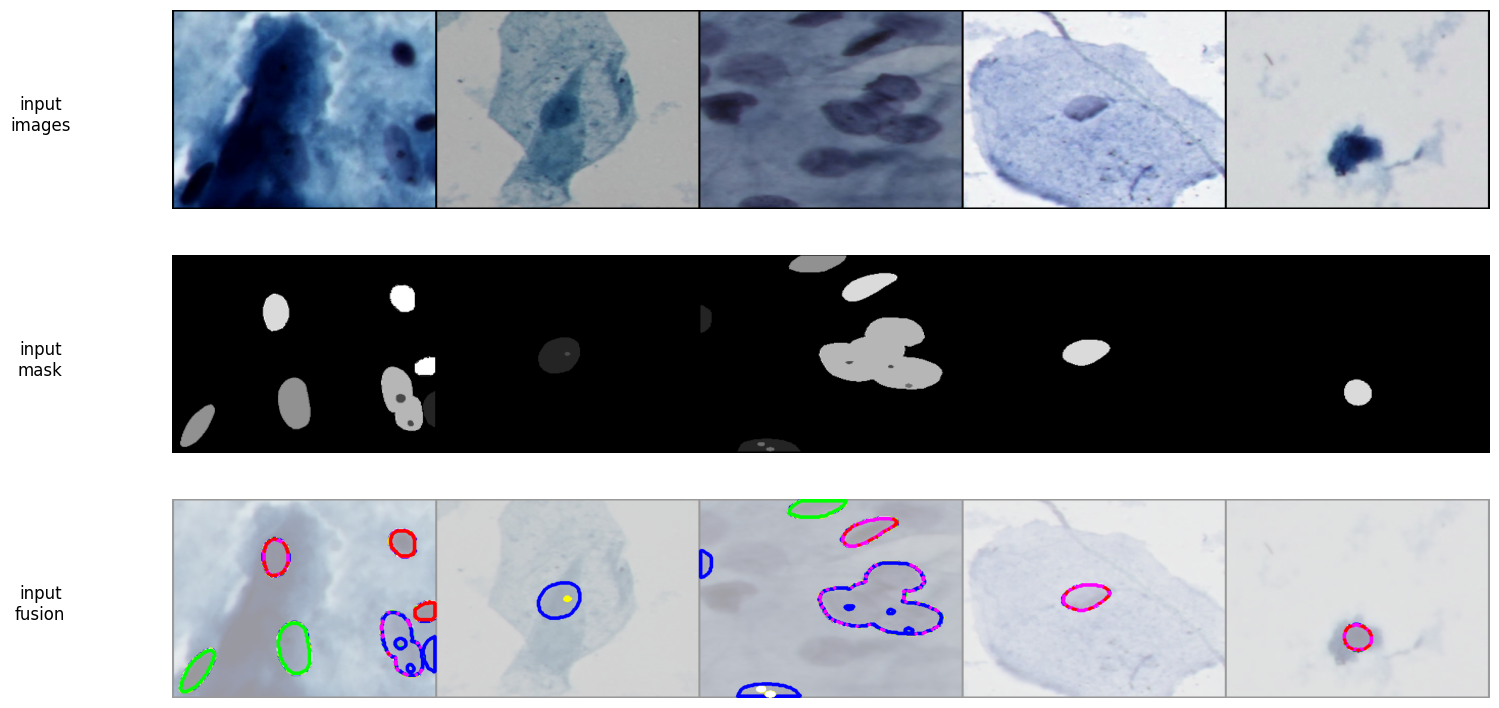

In [9]:
imgs, masks = next(iter(trainloader))
masks = masks.unsqueeze(1) 

show_images(imgs, img_size, masks.float(), mode=False)

## Training

In [9]:
LR = 1e-4
EPOCHS = 60

unet = UNet(num_classes=num_classes).to(device)
optimizer = optim.Adam(unet.parameters(), lr=LR, weight_decay=5e-5)
criterion = nn.CrossEntropyLoss() 

In [10]:
def train_and_validate(unet, trainloader, valloader, criterion, optimizer, EPOCHS, device):
    """
    訓練與驗證模型，記錄每個 epoch 的損失值。
    
    :param unet: 要訓練的 UNet 模型
    :param trainloader: 訓練數據的 DataLoader
    :param valloader: 驗證數據的 DataLoader
    :param criterion: 損失函數 (如 CrossEntropyLoss)
    :param optimizer: 優化器 (如 Adam 或 SGD)
    :param EPOCHS: 訓練的總迭代次數
    :param device: 設備 (如 'cuda' 或 'cpu')
    
    :return: 訓練損失和驗證損失的列表
    """
    train_losses = []  # 記錄每個 epoch 的訓練損失
    val_losses = []    # 記錄每個 epoch 的驗證損失

    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=5e-6)

    for epoch in range(EPOCHS):
        # 訓練模式
        unet.train()  
        epoch_loss = 0
        
        i_bar = tqdm(trainloader, unit='iter', desc=f'Epoch {epoch + 1}/{EPOCHS}')
        for imgs, masks in i_bar:
            imgs, masks = imgs.to(device), masks.to(device)
            masks = masks.squeeze(1)  # 移除 mask 的通道維度，變為 [batch_size, H, W]
            optimizer.zero_grad()
            outputs = unet(imgs)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        train_losses.append(epoch_loss / len(trainloader))
        
        # 驗證模式
        unet.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for imgs, masks in valloader:
                imgs, masks = imgs.to(device), masks.to(device)
                outputs = unet(imgs)
                loss = criterion(outputs, masks)

                val_loss += loss.item()
        
        # 記錄平均驗證損失
        val_losses.append(val_loss / len(valloader))

        scheduler.step()
        
        print(f"Epoch {epoch + 1}/{EPOCHS}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")
    
    return train_losses, val_losses

In [11]:
train_losses, val_losses = train_and_validate(
    unet=unet,
    trainloader=trainloader,
    valloader=valloader,
    criterion=criterion,
    optimizer=optimizer,
    EPOCHS=EPOCHS,
    device=device
)

Epoch 1/60: 100%|██████████| 918/918 [10:50<00:00,  1.41iter/s]


Epoch 1/60, Train Loss: 0.2253, Val Loss: 0.1158


Epoch 2/60: 100%|██████████| 918/918 [11:03<00:00,  1.38iter/s]


Epoch 2/60, Train Loss: 0.1014, Val Loss: 0.0853


Epoch 3/60: 100%|██████████| 918/918 [11:02<00:00,  1.39iter/s]


Epoch 3/60, Train Loss: 0.0844, Val Loss: 0.0767


Epoch 4/60: 100%|██████████| 918/918 [11:00<00:00,  1.39iter/s]


Epoch 4/60, Train Loss: 0.0778, Val Loss: 0.0720


Epoch 5/60: 100%|██████████| 918/918 [11:02<00:00,  1.39iter/s]


Epoch 5/60, Train Loss: 0.0740, Val Loss: 0.0682


Epoch 6/60: 100%|██████████| 918/918 [11:00<00:00,  1.39iter/s]


Epoch 6/60, Train Loss: 0.0718, Val Loss: 0.0671


Epoch 7/60: 100%|██████████| 918/918 [11:00<00:00,  1.39iter/s]


Epoch 7/60, Train Loss: 0.0695, Val Loss: 0.0628


Epoch 8/60: 100%|██████████| 918/918 [10:59<00:00,  1.39iter/s]


Epoch 8/60, Train Loss: 0.0690, Val Loss: 0.0618


Epoch 9/60: 100%|██████████| 918/918 [10:59<00:00,  1.39iter/s]


Epoch 9/60, Train Loss: 0.0667, Val Loss: 0.0690


Epoch 10/60: 100%|██████████| 918/918 [10:59<00:00,  1.39iter/s]


Epoch 10/60, Train Loss: 0.0657, Val Loss: 0.0608


Epoch 11/60: 100%|██████████| 918/918 [10:59<00:00,  1.39iter/s]


Epoch 11/60, Train Loss: 0.0642, Val Loss: 0.0676


Epoch 12/60: 100%|██████████| 918/918 [11:00<00:00,  1.39iter/s]


Epoch 12/60, Train Loss: 0.0633, Val Loss: 0.0606


Epoch 13/60: 100%|██████████| 918/918 [10:59<00:00,  1.39iter/s]


Epoch 13/60, Train Loss: 0.0622, Val Loss: 0.0616


Epoch 14/60: 100%|██████████| 918/918 [10:59<00:00,  1.39iter/s]


Epoch 14/60, Train Loss: 0.0614, Val Loss: 0.0614


Epoch 15/60: 100%|██████████| 918/918 [10:59<00:00,  1.39iter/s]


Epoch 15/60, Train Loss: 0.0605, Val Loss: 0.0577


Epoch 16/60: 100%|██████████| 918/918 [10:59<00:00,  1.39iter/s]


Epoch 16/60, Train Loss: 0.0595, Val Loss: 0.0565


Epoch 17/60: 100%|██████████| 918/918 [11:00<00:00,  1.39iter/s]


Epoch 17/60, Train Loss: 0.0589, Val Loss: 0.0579


Epoch 18/60: 100%|██████████| 918/918 [11:00<00:00,  1.39iter/s]


Epoch 18/60, Train Loss: 0.0581, Val Loss: 0.0565


Epoch 19/60: 100%|██████████| 918/918 [11:00<00:00,  1.39iter/s]


Epoch 19/60, Train Loss: 0.0572, Val Loss: 0.0559


Epoch 20/60: 100%|██████████| 918/918 [10:59<00:00,  1.39iter/s]


Epoch 20/60, Train Loss: 0.0562, Val Loss: 0.0537


Epoch 21/60: 100%|██████████| 918/918 [11:00<00:00,  1.39iter/s]


Epoch 21/60, Train Loss: 0.0552, Val Loss: 0.0539


Epoch 22/60: 100%|██████████| 918/918 [10:59<00:00,  1.39iter/s]


Epoch 22/60, Train Loss: 0.0544, Val Loss: 0.0531


Epoch 23/60: 100%|██████████| 918/918 [11:00<00:00,  1.39iter/s]


Epoch 23/60, Train Loss: 0.0534, Val Loss: 0.0529


Epoch 24/60: 100%|██████████| 918/918 [11:00<00:00,  1.39iter/s]


Epoch 24/60, Train Loss: 0.0524, Val Loss: 0.0507


Epoch 25/60: 100%|██████████| 918/918 [11:00<00:00,  1.39iter/s]


Epoch 25/60, Train Loss: 0.0511, Val Loss: 0.0486


Epoch 26/60: 100%|██████████| 918/918 [10:59<00:00,  1.39iter/s]


Epoch 26/60, Train Loss: 0.0502, Val Loss: 0.0494


Epoch 27/60: 100%|██████████| 918/918 [11:00<00:00,  1.39iter/s]


Epoch 27/60, Train Loss: 0.0493, Val Loss: 0.0481


Epoch 28/60: 100%|██████████| 918/918 [11:00<00:00,  1.39iter/s]


Epoch 28/60, Train Loss: 0.0480, Val Loss: 0.0531


Epoch 29/60: 100%|██████████| 918/918 [11:00<00:00,  1.39iter/s]


Epoch 29/60, Train Loss: 0.0467, Val Loss: 0.0468


Epoch 30/60: 100%|██████████| 918/918 [11:00<00:00,  1.39iter/s]


Epoch 30/60, Train Loss: 0.0454, Val Loss: 0.0481


Epoch 31/60: 100%|██████████| 918/918 [11:00<00:00,  1.39iter/s]


Epoch 31/60, Train Loss: 0.0442, Val Loss: 0.0459


Epoch 32/60: 100%|██████████| 918/918 [10:59<00:00,  1.39iter/s]


Epoch 32/60, Train Loss: 0.0428, Val Loss: 0.0441


Epoch 33/60: 100%|██████████| 918/918 [11:00<00:00,  1.39iter/s]


Epoch 33/60, Train Loss: 0.0417, Val Loss: 0.0435


Epoch 34/60: 100%|██████████| 918/918 [11:00<00:00,  1.39iter/s]


Epoch 34/60, Train Loss: 0.0404, Val Loss: 0.0459


Epoch 35/60: 100%|██████████| 918/918 [11:00<00:00,  1.39iter/s]


Epoch 35/60, Train Loss: 0.0393, Val Loss: 0.0429


Epoch 36/60: 100%|██████████| 918/918 [10:59<00:00,  1.39iter/s]


Epoch 36/60, Train Loss: 0.0379, Val Loss: 0.0423


Epoch 37/60: 100%|██████████| 918/918 [10:59<00:00,  1.39iter/s]


Epoch 37/60, Train Loss: 0.0368, Val Loss: 0.0439


Epoch 38/60: 100%|██████████| 918/918 [11:00<00:00,  1.39iter/s]


Epoch 38/60, Train Loss: 0.0358, Val Loss: 0.0426


Epoch 39/60: 100%|██████████| 918/918 [11:00<00:00,  1.39iter/s]


Epoch 39/60, Train Loss: 0.0342, Val Loss: 0.0397


Epoch 40/60: 100%|██████████| 918/918 [11:00<00:00,  1.39iter/s]


Epoch 40/60, Train Loss: 0.0331, Val Loss: 0.0390


Epoch 41/60: 100%|██████████| 918/918 [11:00<00:00,  1.39iter/s]


Epoch 41/60, Train Loss: 0.0323, Val Loss: 0.0388


Epoch 42/60: 100%|██████████| 918/918 [10:59<00:00,  1.39iter/s]


Epoch 42/60, Train Loss: 0.0309, Val Loss: 0.0380


Epoch 43/60: 100%|██████████| 918/918 [10:59<00:00,  1.39iter/s]


Epoch 43/60, Train Loss: 0.0296, Val Loss: 0.0382


Epoch 44/60: 100%|██████████| 918/918 [11:00<00:00,  1.39iter/s]


Epoch 44/60, Train Loss: 0.0289, Val Loss: 0.0370


Epoch 45/60: 100%|██████████| 918/918 [11:05<00:00,  1.38iter/s]


Epoch 45/60, Train Loss: 0.0280, Val Loss: 0.0377


Epoch 46/60: 100%|██████████| 918/918 [11:09<00:00,  1.37iter/s]


Epoch 46/60, Train Loss: 0.0269, Val Loss: 0.0369


Epoch 47/60: 100%|██████████| 918/918 [11:17<00:00,  1.35iter/s]


Epoch 47/60, Train Loss: 0.0261, Val Loss: 0.0376


Epoch 48/60: 100%|██████████| 918/918 [11:19<00:00,  1.35iter/s]


Epoch 48/60, Train Loss: 0.0252, Val Loss: 0.0378


Epoch 49/60: 100%|██████████| 918/918 [11:12<00:00,  1.37iter/s]


Epoch 49/60, Train Loss: 0.0245, Val Loss: 0.0356


Epoch 50/60: 100%|██████████| 918/918 [12:13<00:00,  1.25iter/s]


Epoch 50/60, Train Loss: 0.0239, Val Loss: 0.0367


Epoch 51/60: 100%|██████████| 918/918 [12:19<00:00,  1.24iter/s]


Epoch 51/60, Train Loss: 0.0230, Val Loss: 0.0362


Epoch 52/60: 100%|██████████| 918/918 [11:03<00:00,  1.38iter/s]


Epoch 52/60, Train Loss: 0.0223, Val Loss: 0.0356


Epoch 53/60: 100%|██████████| 918/918 [11:03<00:00,  1.38iter/s]


Epoch 53/60, Train Loss: 0.0219, Val Loss: 0.0344


Epoch 54/60: 100%|██████████| 918/918 [11:03<00:00,  1.38iter/s]


Epoch 54/60, Train Loss: 0.0213, Val Loss: 0.0351


Epoch 55/60: 100%|██████████| 918/918 [11:03<00:00,  1.38iter/s]


Epoch 55/60, Train Loss: 0.0209, Val Loss: 0.0360


Epoch 56/60: 100%|██████████| 918/918 [11:04<00:00,  1.38iter/s]


Epoch 56/60, Train Loss: 0.0203, Val Loss: 0.0357


Epoch 57/60: 100%|██████████| 918/918 [11:06<00:00,  1.38iter/s]


Epoch 57/60, Train Loss: 0.0199, Val Loss: 0.0350


Epoch 58/60: 100%|██████████| 918/918 [11:04<00:00,  1.38iter/s]


Epoch 58/60, Train Loss: 0.0197, Val Loss: 0.0356


Epoch 59/60: 100%|██████████| 918/918 [11:06<00:00,  1.38iter/s]


Epoch 59/60, Train Loss: 0.0193, Val Loss: 0.0358


Epoch 60/60: 100%|██████████| 918/918 [11:27<00:00,  1.33iter/s]


Epoch 60/60, Train Loss: 0.0191, Val Loss: 0.0348


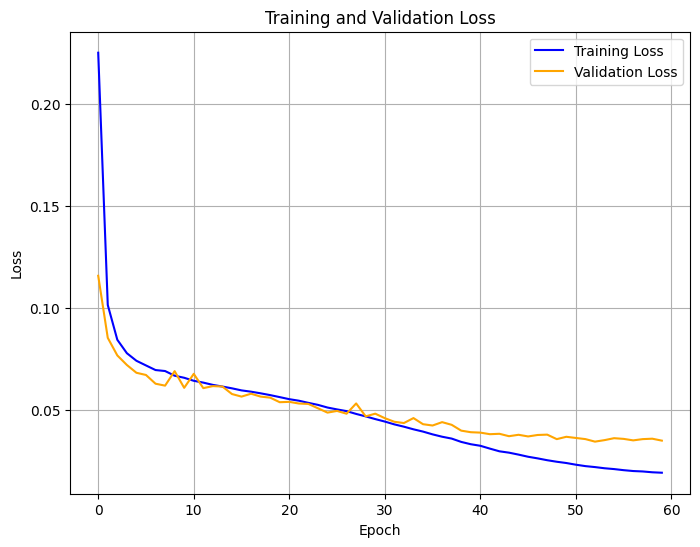

In [12]:
plot_training_validation_loss(train_losses, val_losses)

In [13]:
# torch.save(unet.state_dict(), "params/unet.pth")
# 0.034

## Test

In [10]:
torch.cuda.empty_cache()

In [11]:
model = UNet(num_classes=num_classes).to(device)
model.load_state_dict(torch.load("params/unet.pth"))

C:\Users\wei\AppData\Local\Temp\ipykernel_32660\3072288281.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("params/unet.pth"))


<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


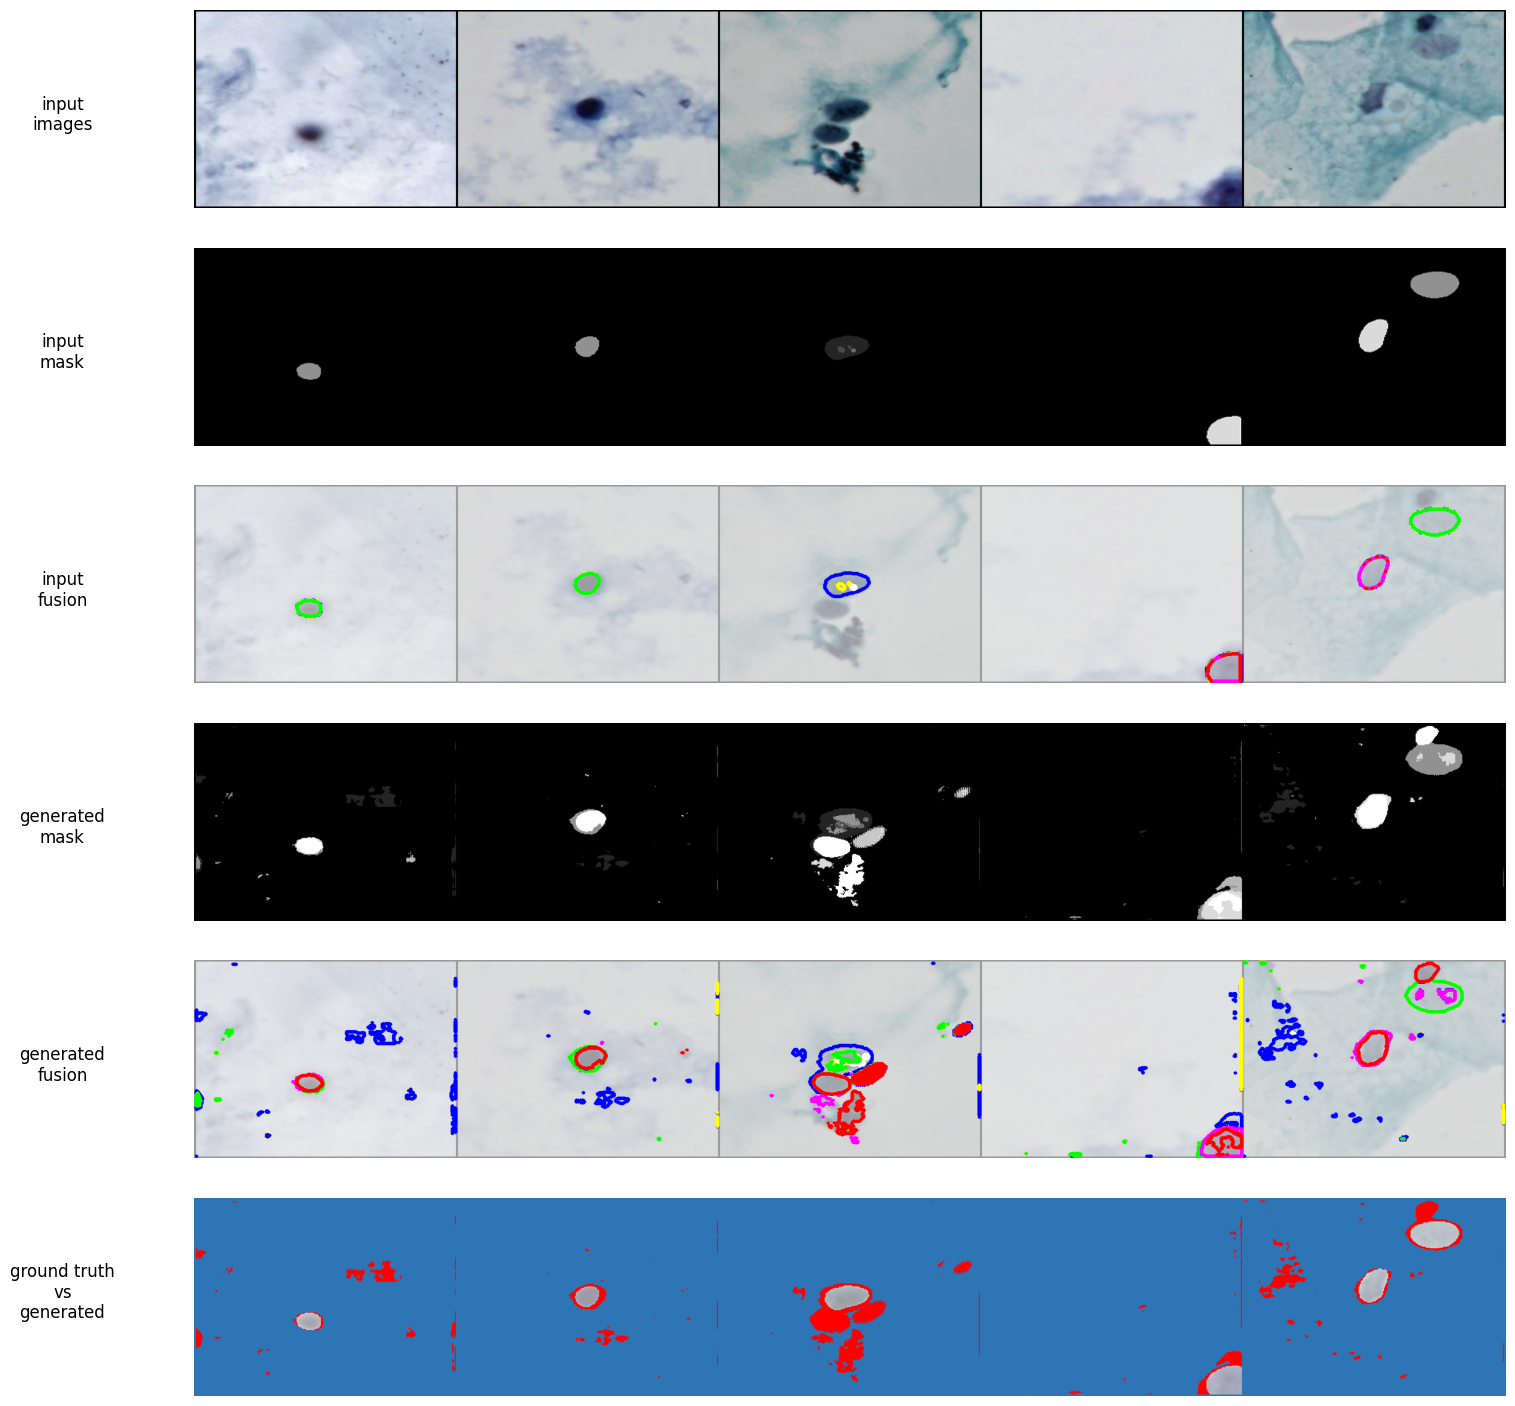

In [12]:
model.eval()
with torch.no_grad():
    imgs, masks = next(iter(testloader))
    imgs, masks = imgs.to(device), masks.to(device)
    outputs = model(imgs)

pred2show = compress_channel(outputs, 0.1)
masks = masks.unsqueeze(1) 
show_images(imgs, img_size, masks.float(), gen_masks=pred2show , mode=True)

In [36]:
def test_model(model, testloader, num_classes, device):
    """
    測試模型性能並計算各種評估指標。

    :param model: 已訓練的模型
    :param testloader: 測試數據加載器
    :param num_classes: 數據集中類別的數量
    :param device: 設備 (如 'cuda' 或 'cpu')

    :return: 包含所有測試指標的字典
    """
    # 初始化指標字典
    all_metrics = {'PA': [], 'cPA': [], 'mPA': [], 'Dice': [], 'IoU': [], 'mIoU': [], 'mAP': []}

    # 設置模型為評估模式
    model.eval()

    # 禁用梯度計算
    with torch.no_grad():
        for imgs, masks in testloader:
            # 將數據移動到指定設備
            imgs, masks = imgs.to(device), masks.to(device)
            
            # 獲取模型輸出
            outputs = model(imgs)
            
            # 預測類別 (取概率最大的類別)
            preds = torch.argmax(outputs, dim=1)

            # 計算指標
            pa = pixel_accuracy(preds, masks) 
            cpa = class_pixel_accuracy(preds, masks, num_classes)
            mpa = mean_pixel_accuracy(preds, masks, num_classes)
            dice = dice_coefficient(preds, masks, num_classes)
            iou_scores = iou(preds, masks, num_classes)
            miou = mean_iou(preds, masks, num_classes)
            map_score = compute_mAP(preds, masks)

            # 保存指標 (直接轉為 float)
            all_metrics['PA'].append(float(pa))
            all_metrics['cPA'].append(cpa)
            all_metrics['mPA'].append(float(mpa))
            all_metrics['Dice'].append(dice)
            all_metrics['IoU'].append(iou_scores)
            all_metrics['mIoU'].append(float(miou))
            all_metrics['mAP'].append(float(map_score))

    # 返回測試指標字典
    return all_metrics

In [37]:
metrics = test_model(model, testloader, num_classes, device)

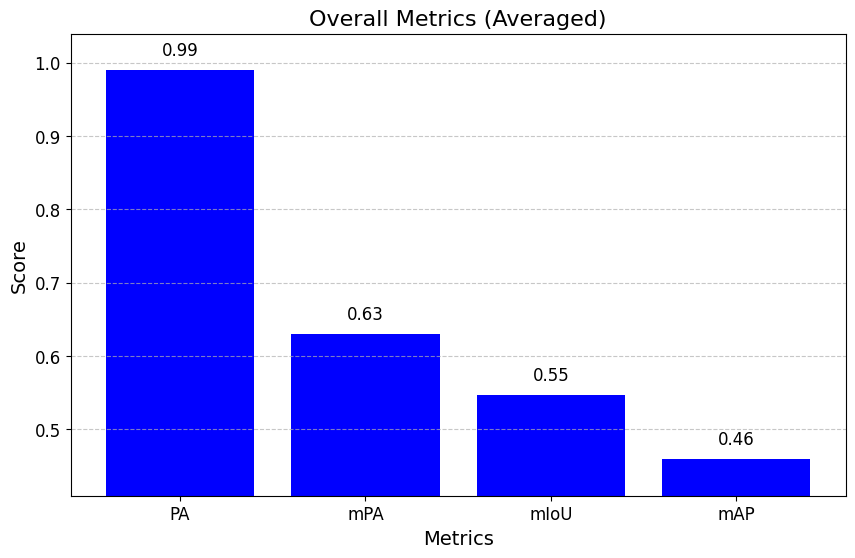

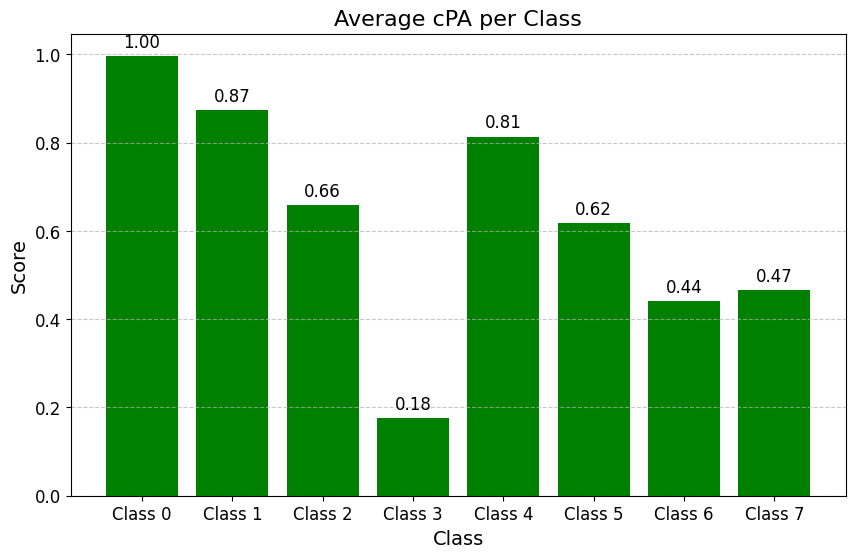

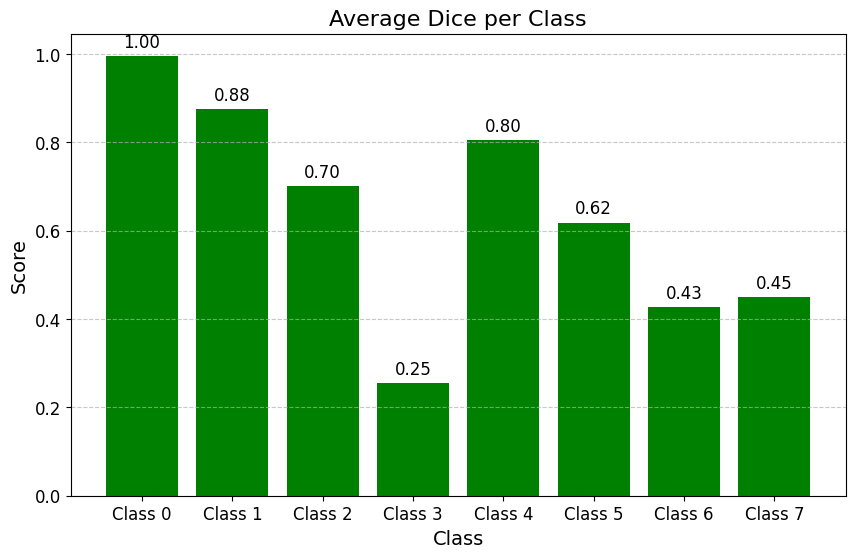

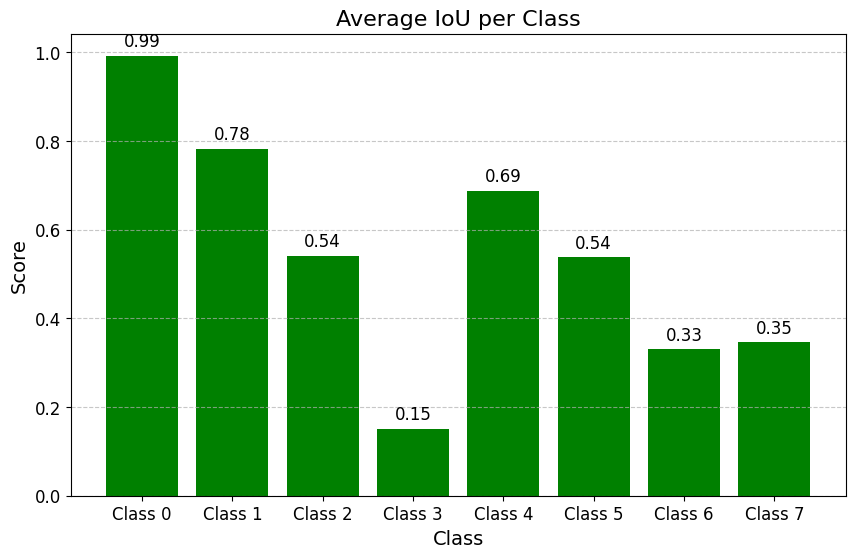

In [42]:
visualize_metrics(metrics, num_classes=num_classes)